## Visualization
What does an input and its label look like?

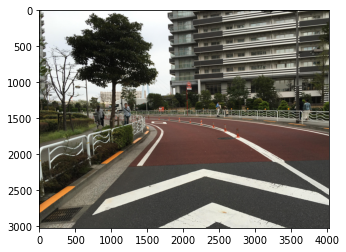

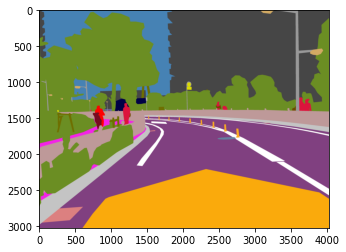

In [1]:
import os
from keras import utils
import matplotlib.pyplot as plt

train_x_src_dir = 'data/training/images'
train_y_src_dir = 'data/training/v2.0/labels'
val_x_src_dir = 'data/validation/images'
val_y_src_dir = 'data/validation/v2.0/labels'
test_src_dir = 'data/testing/images'

def get_image(my_dir, file_name, color_mode='rgb'):
    return utils.load_img(os.path.join(my_dir, file_name), color_mode=color_mode)

def get_first(my_dir, color_mode='rgb'):
    file_name = os.listdir(my_dir)[0]
    return get_image(my_dir, file_name, color_mode)

def show_first(my_dir, color_mode='rgb'):
    image = get_first(my_dir, color_mode)
    image = utils.img_to_array(image)
    image /= 255
    
    plt.imshow(image)
    plt.show()

show_first(train_x_src_dir)
show_first(train_y_src_dir)

## Encoding
For each label, categories are encoded as colors (tuples). Let's encode them as integers instead:

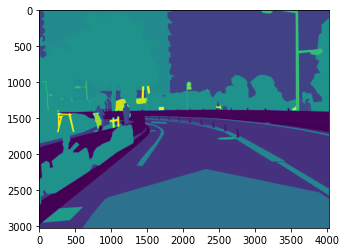

In [2]:
import json
import numpy as np
from keras import layers
import tensorflow as tf

config_file = open('data/config_v2.0.json')
config = json.load(config_file)
cats_to_colors = list(map(lambda x: x['color'], config['labels']))

def to_categories(colors):
    label = np.zeros((colors.shape[0], colors.shape[1], 1))
    
    for i in range(len(cats_to_colors)):
        color = cats_to_colors[i]
        mask = np.all(colors == color, axis=2)
        label[mask] = [i]
    
    return label

label = get_first(train_y_src_dir)
label = utils.img_to_array(label)
label = to_categories(label)

plt.imshow(label)
plt.show()

## File Structure
Let's make the file structure:

In [3]:
import shutil

base_dir = 'data_small'

# def rm_dir(my_dir):
#     if os.path.exists(my_dir):
#         shutil.rmtree(my_dir)

# rm_dir(base_dir)

def make_dir(my_dir):
    if not os.path.exists(my_dir):
        os.mkdir(my_dir)

make_dir(base_dir)

def sub_dir(base_dir, sub_dir):
    sub_dir = os.path.join(base_dir, sub_dir)
    make_dir(sub_dir)
    return sub_dir

train_dir = sub_dir(base_dir, 'train')
train_x_dir = sub_dir(train_dir, 'x')
train_y_dir = sub_dir(train_dir, 'y')

val_dir = sub_dir(base_dir, 'val')
val_x_dir = sub_dir(val_dir, 'x')
val_y_dir = sub_dir(val_dir, 'y')

test_dir = sub_dir(base_dir, 'test')

## Preprocessing
Let's copy over some images and labels. Now's a good time to do some preprocessing as well. This might take a while, so if you've already run this cell, then you can set `skip_preprocessing` to `True`:

In [4]:
import random

total_size = 1000
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = int(total_size * test_ratio)

input_width = 512
input_height = 512
resize = layers.Resizing(input_height, input_width)
resize_nearest = layers.Resizing(input_height, input_width, interpolation='nearest')

skip_preprocessing = True

def clear_dir(my_dir):
    file_names = os.listdir(my_dir)
    
    for file_name in file_names:
        os.remove(os.path.join(my_dir, file_name))

def process_images(src_dir, dest_dir, file_names):
    clear_dir(dest_dir)
    
    for file_name in file_names:
        image = get_image(src_dir, file_name)
        image = utils.img_to_array(image)
        image = resize(image)
        utils.save_img(os.path.join(dest_dir, file_name), image)

def set_ext(file_name, ext):
    return os.path.splitext(file_name)[0] + ext

def process_labels(src_dir, dest_dir, file_names):
    clear_dir(dest_dir)
    
    for file_name in file_names:
        label = get_image(src_dir, file_name)
        label = utils.img_to_array(label)
        label = resize_nearest(label)
        label = to_cats(label)
        utils.save_img(os.path.join(dest_dir, file_name), label, scale=False)

if skip_preprocessing == False:
    file_names = random.sample(os.listdir(train_x_src_dir), train_size)
    process_images(train_x_src_dir, train_x_dir, file_names)

    file_names = list(map(lambda x: set_ext(x, '.png'), file_names))
    process_labels(train_y_src_dir, train_y_dir, file_names)

    file_names = random.sample(os.listdir(val_x_src_dir), val_size)
    process_images(val_x_src_dir, val_x_dir, file_names)
    
    file_names = list(map(lambda x: set_ext(x, '.png'), file_names))
    process_labels(val_y_src_dir, val_y_dir, file_names)
    
    file_names = random.sample(os.listdir(test_src_dir), test_size)
    process_images(test_src_dir, test_dir, file_names)

## Naive Autoencoder

In [19]:
from keras import models
from keras import optimizers
from keras import backend

input_shape = (input_width, input_height, 3)

encoder = models.Sequential()
encoder.add(layers.Conv2D(4, kernel_size=3, padding='same', activation='relu', input_shape=(input_shape)))
encoder.add(layers.MaxPool2D(pool_size=2))
encoder.add(layers.Conv2D(8, kernel_size=3, padding='same', activation='relu'))
encoder.add(layers.MaxPool2D(pool_size=2))
encoder.add(layers.Conv2D(16, kernel_size=3, padding='same', activation='relu'))
encoder.add(layers.MaxPool2D(pool_size=2))

decoder = models.Sequential()

decoder.add(layers.Conv2DTranspose(
    8,
    kernel_size=3,
    strides=2,
    padding='same',
    activation='relu',
    input_shape=(input_width // 8, input_height // 8, 16)))

decoder.add(layers.Conv2DTranspose(4, kernel_size=3, strides=2, padding='same', activation='relu'))
decoder.add(layers.Conv2DTranspose(len(cats_to_colors), kernel_size=3, strides=2, padding='same', activation='softmax'))

autoencoder = models.Sequential([encoder, decoder])
autoencoder.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam())
autoencoder.summary()
backend.clear_session()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 16)        1576      
                                                                 
 sequential_1 (Sequential)   (None, 512, 512, 124)     6040      
                                                                 
Total params: 7,616
Trainable params: 7,616
Non-trainable params: 0
_________________________________________________________________


## Datasets & Generators

Found 800 files belonging to 1 classes.
Found 800 files belonging to 1 classes.
Found 100 files belonging to 1 classes.
Found 100 files belonging to 1 classes.
(512, 512)


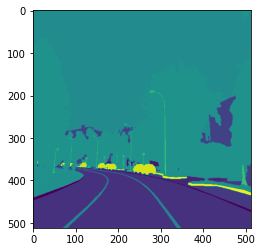

In [23]:
batch_size = 5
normalizer = layers.Rescaling(1./255)
reshaper = layers.Reshape((input_height, input_width), input_shape=(input_height, input_width, 1))

def get_x_dataset(my_dir):
    dataset = utils.image_dataset_from_directory(
        my_dir,
        labels=None,
        batch_size=batch_size,
        image_size=(input_height, input_width),
        shuffle=False
    )
    
    dataset = dataset.map(lambda x: normalizer(x))
    return dataset

def get_y_dataset(my_dir):
    dataset = utils.image_dataset_from_directory(
        my_dir,
        labels=None,
        color_mode='grayscale',
        batch_size=batch_size,
        image_size=(input_height, input_width),
        shuffle=False,
        interpolation='nearest'
    )
    
    dataset = dataset.map(lambda x: reshaper(x))
    return dataset

train_x_dataset = get_x_dataset(train_x_dir)
train_y_dataset = get_y_dataset(train_y_dir)
train_gen = zip(train_x_dataset.repeat(), train_y_dataset.repeat())

val_x_dataset = get_x_dataset(val_x_dir)
val_y_dataset = get_y_dataset(val_y_dir)
val_gen = zip(val_x_dataset.repeat(), val_y_dataset.repeat())

batch = list(train_y_dataset.take(1))[0]
print(batch[0].shape)
plt.imshow(batch[0])
plt.show()

## Training

In [21]:
num_epochs = 4

history = autoencoder.fit(
    train_gen,
    steps_per_epoch=train_size//batch_size,
    epochs=num_epochs,
    validation_data=val_gen,
    validation_steps=val_size//batch_size
)

Epoch 1/4
160/160 [==============================] - 70s 424ms/step - loss: 3.2247 - val_loss: 2.4142
Epoch 2/4
160/160 [==============================] - 68s 424ms/step - loss: 2.3705 - val_loss: 2.3237
Epoch 3/4
160/160 [==============================] - 67s 422ms/step - loss: 2.3163 - val_loss: 2.2862
Epoch 4/4
160/160 [==============================] - 67s 421ms/step - loss: 2.2824 - val_loss: 2.2545


## Predictions
How do predicted labels on validation inputs compare to actual labels?

In [33]:
import matplotlib.pyplot as plt
num_images = 5
fig_width = 7.5

# predictions = autoencoder.predict(
#     val_x_dataset,
#     batch_size=batch_size
# )
image = list(val_x_dataset.take(1))[0]
prediction = autoencoder.predict_step(image)

batch = list(val_y_dataset.take(1))[0]
figure, axes = plt.subplots(num_images, 2, figsize=(fig_width, fig_width / 2 * num_images))
indices = random.sample(range(batch_size), num_images)

for i in range(num_images):
    axes[i][0].imshow(batch[indices[i]])
    axes[i][0].set_aspect('auto')
#     print(predictions[indices[i]])
    axes[i][1].imshow(predictions[indices[i]])
    axes[i][1].set_aspect('auto')

plt.show()

ResourceExhaustedError: Exception encountered when calling layer "conv2d_transpose_2" (type Conv2DTranspose).

OOM when allocating tensor with shape[5,124,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2DBackpropInput]

Call arguments received by layer "conv2d_transpose_2" (type Conv2DTranspose):
  • inputs=tf.Tensor(shape=(5, 256, 256, 4), dtype=float32)

What do predictions on test inputs look like?

In [ ]:
test_dataset = get_dataset(test_dir)
predictions = autoencoder.predict(test_dataset)
batch = list(test_dataset.take(1))[0]
figure, axes = plt.subplots(num_images, 2, figsize=(fig_width, fig_width / 2 * num_images))
indices = random.sample(range(batch_size), 5)

for data in dataset:
    for i in range(num_images):
        axes[i][0].imshow(data[indices[i]])
        axes[i][0].set_aspect('auto')
        axes[i][1].imshow(predictions[indices[i]])
        axes[i][1].set_aspect('auto')

plt.show()